- ### Planteamiento del problema:

Predecir a partir de medidas diagnósticas si un paciente tiene diabetes o no.

In [1]:
# Se importa el dataset
import pandas as pd

train_data = pd.read_csv("/workspaces/EDA/data/processed/diabetes_train.csv")
test_data = pd.read_csv("/workspaces/EDA/data/processed/diabetes_test.csv")

In [2]:
X_train = train_data.drop("Outcome", axis=1)
X_test = test_data.drop("Outcome", axis=1)

y_train = train_data["Outcome"]
y_test = test_data["Outcome"]

- #### Entrenamiento del modelo

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(random_state = 42)

In [5]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [6]:
y_predict = model.predict(X_test)
y_predict

array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [7]:
accuracy = accuracy_score(y_test, y_predict)
print('Precisión')
print(round(accuracy,6))

Precisión
0.727273


Variando hiperparámetros primero RandomSearch

In [18]:
import numpy as np

hyperparams = {
    'n_estimators': list(range(10,301,20)),
    'learning_rate': np.arange(0.001,0.2,0.001),
    'subsample' : np.arange(0.1, 1.1, 0.1)
}

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

modelrandom = XGBClassifier(random_state = 42)
random_search = RandomizedSearchCV(estimator = modelrandom, 
                                   param_distributions = hyperparams, scoring = 'accuracy', n_jobs = -1, cv = 5, n_iter=50)

In [20]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
       0.163, 0.164, 0.165, 0.166, 0.167, 0.168, 0.169, 0.17 , 0.171,
       0.172, 0.173, 0.174, 0.175, 0.176, 0.177, 0.178, 0.179, 0.18 ,
       0.181, 0.182, 0.183, 0.184, 0.185, 0.186, 0.187, 0.188, 0.189,
       0.19 , 0.191, 0.192, 0.193, 0.194, 0.195, 0.196, 0.197, 0.198,
       0.199]),
                                        'n_estimators': [10, 30, 50, 70, 90,
                                                         110, 130, 150, 170,
                                                         190, 210, 230, 250,
                                                         270, 290],
                                        'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   scoring='accuracy')

In [21]:
random_search.best_params_

{'subsample': 0.30000000000000004, 'n_estimators': 10, 'learning_rate': 0.199}

In [23]:
from xgboost import XGBClassifier

best_model_random = XGBClassifier(subsample= 0.3, 
                                  n_estimators= 10, 
                                  learning_rate= 0.199,
                                  random_state =42)

best_model_random.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.199, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [24]:
y_predic_best_random = best_model_random.predict(X_test)

In [39]:
accuracy_random = accuracy_score(y_test, y_predic_best_random)
print(f"Precisión: {round(accuracy_random,6)}")

Precisión: 0.753247


A partir de los valores del RandomSearch, se hace un GridSearch

In [26]:
random_search.best_params_

{'subsample': 0.30000000000000004, 'n_estimators': 10, 'learning_rate': 0.199}

In [31]:
hyperparams2 = {
    'n_estimators': np.arange(8,13),
    'learning_rate': np.arange(0.1,0.31,0.05),
    'subsample' : np.arange(0.2, 0.5, 0.1)
}

In [32]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

modelgrid = XGBClassifier(random_state = 42)
grid_search = GridSearchCV(estimator = modelgrid, 
                                   param_grid = hyperparams2, scoring = 'accuracy', n_jobs = -1, cv = 5)

In [33]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                         'n_estimators': array([ 8,  9, 10, 11, 12]),
                         'subsample': array([0.2, 0.3, 0.4])},
             scoring='accuracy')

In [34]:
grid_search.best_params_

{'learning_rate': 0.20000000000000004,
 'n_estimators': 10,
 'subsample': 0.30000000000000004}

In [35]:
best_model_grid = XGBClassifier(subsample= 0.3,
                               n_estimators= 10, 
                               learning_rate= 0.2,
                               random_state=42)

In [36]:
best_model_grid.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [37]:
y_predic_best_grid = best_model_grid.predict(X_test)

In [38]:
accuracy_grid = accuracy_score(y_test, y_predic_best_grid)
print(f"Precisión: {round(accuracy_grid,6)}")

Precisión: 0.753247


In [40]:
print(f'La mejoría con hiperparámetros luego de RandomSearch y GridSearch fue de: {round(100*((accuracy_grid - accuracy)/accuracy),3)}%')

La mejoría con hiperparámetros luego de RandomSearch y GridSearch fue de: 3.571%


El modelo Boost dio un mejor rendimiento que el Random Forest

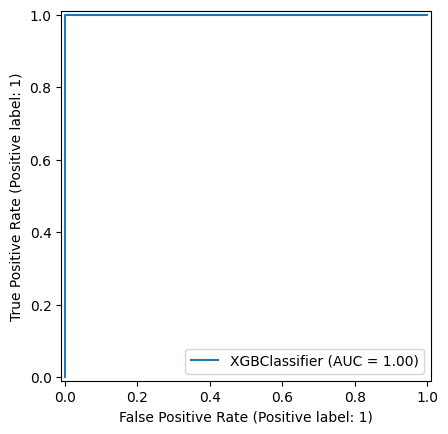

In [44]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(estimator=best_model_grid,
                               X=X_test,
                               y=y_predic_best_grid)

In [42]:
from pickle import dump

dump(best_model_grid, open("../models/best_model_xgboost_classifier.sav", "wb"))